# Recap

In [previous](./ziln.html) [blog posts](./ziln2.html) we looked at estimating dependencies between microbes in a microbiome [Dataset and Baseline Methodology: @ZiLN].  We saw that my custom method, `antGLasso`, did not perform as well as the method we compared against - in fact, it seemed as though `antGLasso` was saying nothing of value!

After much investigation, this was due to an error in my implementation, which I have now fixed.  Let's see how it compares, using their assortativity metric!

In [8]:
library(igraph)
library(ggplot2)

## Load in the Data

<details>
    <summary><b style="color:#C0CF96">Code here</b></summary>

## `antGLasso`

In [484]:
antGLasso.mat <- as.matrix(
    read.csv(
        "./localdata/antGlasso-output-iter-raws--fast-test.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)


In [485]:
# These bounds were chosen by eye.
#upper.bound <- 0.15
#lower.bound <- 0.05
upper.bound <- 0.6
lower.bound <- 0.07
sum(abs(antGLasso.mat) > upper.bound) / 2 - 282.5
sum(abs(antGLasso.mat) > lower.bound) / 2 - 282.5
antGLasso.lambdas <- exp(0:19 * (log(upper.bound) - log(lower.bound)) / 19 + log(lower.bound))

[1] 26

[1] 14335

In [488]:
# Construct the regularized antGLasso matrices
threshold.matrix <- function(mat., threshold) {
    mat <- matrix(0, dim(mat.)[[1]], dim(mat.)[[2]])
    mat[abs(mat.) < threshold] = 0
    mat[abs(mat.) > threshold] = 1
    diag(mat) <- 0
    return(mat)
}
num.elements <- function(mat) {
    sum(mat != 0)
}
antGLasso.path <- lapply(
    antGLasso.lambdas,
    function(thresh) threshold.matrix(antGLasso.mat, thresh)
)

## `ZiLN`

In [11]:
# Load the data
load("localdata/ll_deep.rda")

# Rename the taxmat columns to something more informative
colnames(taxmat) <- c(
    "Domain",
    "Phylum",
    "Class",
    "Order",
    "Family",
    "Genus"
)

# Load the libraries
source("./localdata/Zi-LN-master/inference.R")
source("./localdata/Zi-LN-master/utils/utils.R")
library("huge")
library("igraph")

# Get a boolean 1135x3957 matrix of whether the species
# was found in the person or not
nonzeros <- counts > 0

# Get the number of distinct people that possessed each species
num.nonzeros <- apply(nonzeros, 2, sum)

# Get the total amount of people
total.cells <- dim(counts)[1]

# Only keep the species who appear in more than 20% of the people
keep.indices <- (num.nonzeros / total.cells) > 0.2
counts_el <- as.matrix(counts[, keep.indices])
write.csv(counts_el, "./localdata/filtered-raw-counts-ziln.csv")

taxmat_el <- taxmat[keep.indices,]

# Get the zs
options(warn = -1) # turn warnings off because otherwise it's gonna scream...
zs <- infer_Z(counts_el)

In [124]:
# Get the matrix for ZiLN methodology
ziln.lambdas <- 10^seq(-0.1, -1.1, by=-0.05)
ziln.path <- huge(zs, lambda=ziln.lambdas)$path

Conducting Meinshausen & Buhlmann graph estimation (mb)....done


In [125]:
num.elements(ziln.path[[1]])
num.elements(ziln.path[[20]])

[1] 38

[1] 13752

</details>

# Plotting Utility Functions

<details>
    <summary><b style="color:#C0CF96">Code here</b></summary>

In [26]:
get.assortativity.at.level <- function(adjacency.graph, taxmat, taxa.level) {
    groups <- as.integer(as.factor(taxmat[, taxa.level]))
    return(assortativity(adjacency.graph, groups))
}

get.assortativity.at.levels <- function(adjacency.graph, taxmat) {
    curried.assortativity <- function(taxa.level) get.assortativity.at.level(
        adjacency.graph,
        taxmat,
        taxa.level
    )
    return(
        lapply(
            colnames(taxmat),
            curried.assortativity
        )[2:length(colnames(taxmat))]
    )        
}

In [27]:
plot.all.assortativities <- function(path, taxmat, lambdas) {
    graphs <- lapply(
        lapply(path, graph.adjacency),
        as.undirected
    )
    assortativities <- lapply(
        graphs,
        function(graph) get.assortativity.at.levels(graph, taxmat)
    )

    # Remove first element as full of NaNs
    assortativities <- assortativities[2:length(assortativities)]
    lambdas.short <- lambdas[2:length(lambdas)]
    
    assortativities.1 <- as.numeric(lapply(assortativities, function(l) l[[1]]))
    assortativities.2 <- as.numeric(lapply(assortativities, function(l) l[[2]]))
    assortativities.3 <- as.numeric(lapply(assortativities, function(l) l[[3]]))
    assortativities.4 <- as.numeric(lapply(assortativities, function(l) l[[4]]))
    assortativities.5 <- as.numeric(lapply(assortativities, function(l) l[[5]]))
    ggplot(
        data.frame(assortativities.1),
        aes(x=lambdas.short)
    ) +
        geom_line(aes(y = assortativities.1, color = "Phylum")) +
        geom_line(aes(y = assortativities.2, color = "Class")) +
        geom_line(aes(y = assortativities.3, color = "Order")) +
        geom_line(aes(y = assortativities.4, color = "Family")) +
        geom_line(aes(y = assortativities.5, color = "Genus")) +
        scale_colour_manual("", 
            breaks = c("Phylum", "Class", "Order", "Family", "Genus"),
            values = c("black", "blue", "maroon", "red", "orange")
        ) +
        theme(legend.position = "top") +
        labs(x = "Regularization parameter lambda", y = "Assortativities") +
        ggtitle("Assortativities at different taxonomic levels")
}

In [175]:
plot.compared.assortativities <- function(paths, taxmat, line.names) {
    final.plot <- ggplot()
    min.edges <- 10000000
    max.edges <- 0
    for (i in 1:length(paths)) {
        path <- paths[[i]]
        graphs <- lapply(
            lapply(path, graph.adjacency),
            as.undirected
        )
        assortativities <- lapply(
            graphs,
            function(graph) get.assortativity.at.levels(graph, taxmat)
        )

        # Remove first element as full of NaNs
        #assortativities <- assortativities[2:length(assortativities)]
        #lambdas.short <- lambdas[2:length(lambdas)]

        x.sparsity <- sapply(path, num.elements)
        min.edges <- min(min.edges, min(x.sparsity))
        max.edges <- max(max.edges, max(x.sparsity))

        assortativities.1 <- as.numeric(lapply(assortativities, function(l) l[[1]]))
        assortativities.2 <- as.numeric(lapply(assortativities, function(l) l[[2]]))
        assortativities.3 <- as.numeric(lapply(assortativities, function(l) l[[3]]))
        assortativities.4 <- as.numeric(lapply(assortativities, function(l) l[[4]]))
        assortativities.5 <- as.numeric(lapply(assortativities, function(l) l[[5]]))
              
        final.plot <- final.plot +
            geom_line(
                aes_string(
                    x=x.sparsity,
                    y=assortativities.1,
                    color=shQuote("Phylum"),
                    linetype=line.names[[i]]
                )
            ) +
            geom_line(
                aes_string(
                    x=x.sparsity,
                    y=assortativities.2,
                    color=shQuote("Class"),
                    linetype=line.names[[i]]
                )
            ) +
            geom_line(
                aes_string(
                    x=x.sparsity,
                    y=assortativities.3,
                    color=shQuote("Order"),
                    linetype=line.names[[i]]
                )
            ) +
            geom_line(
                aes_string(
                    x=x.sparsity,
                    y=assortativities.4,
                    color=shQuote("Family"),
                    linetype=line.names[[i]]
                )
            ) +
            geom_line(
                aes_string(
                    x=x.sparsity,
                    y=assortativities.5,
                    color=shQuote("Genus"),
                    linetype=line.names[[i]]
                )
            )
    }
                                           
    final.plot +
        scale_x_log10() + 
        scale_colour_manual("", 
            breaks = c("Phylum", "Class", "Order", "Family", "Genus"),
            values = c("black", "blue", "maroon", "red", "orange")
        ) +
        theme(legend.position = "top") +
        labs(x = "Number of Edges", y = "Assortativities") +
        ggtitle("Assortativities at different taxonomic levels")# +
        #xlim(min.edges, max.edges)
}

</details>

# Make Plots

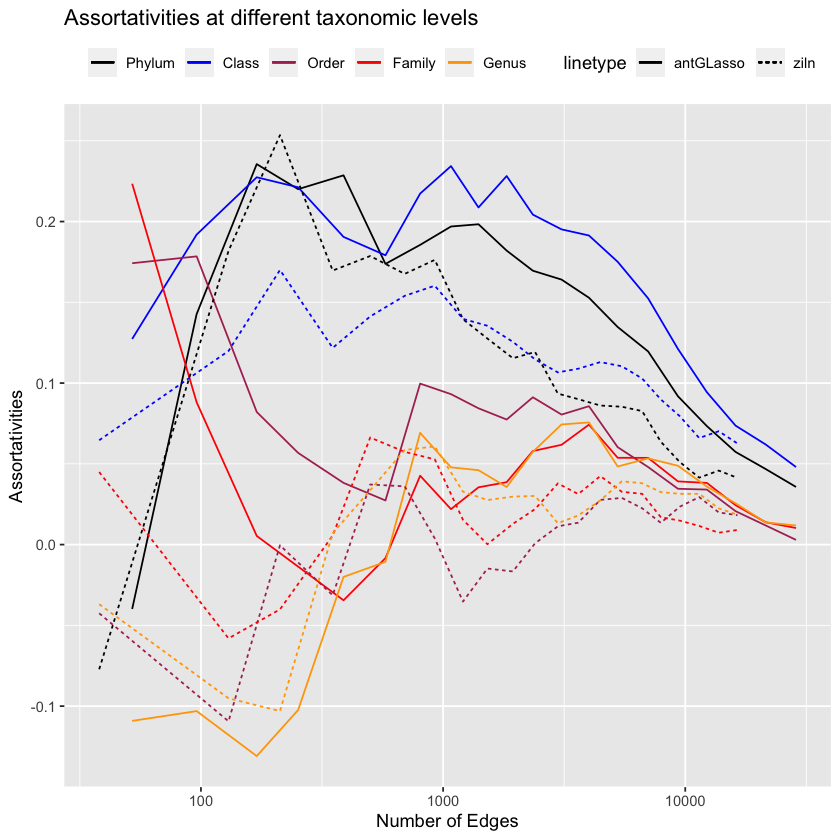

In [489]:
plot.compared.assortativities(
    list(antGLasso.path, ziln.path),
    taxmat_el,
    list(shQuote("antGLasso"), shQuote("ziln"))
)

This looks wonderful!  `antGLasso` and `ziln` perform similarly.

(Don't try to interpret the low-edges happenings on the graph, it's very noisy.  @ZiLN considered the number of edges to be ~1200, which conveniently is about the area where our algorithm clearly outperforms it on the low-level taxonomies!^[Assuming you believe assortativity is something to be maximized, whereas really it shouldn't be (then the graphs would be boring, it would only be useful for predicting phylogeny of unknown species) - instead assortativity is just a validation measure to show that our graphs are sensible.])